In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 91% 57.0M/62.6M [00:00<00:00, 106MB/s]
100% 62.6M/62.6M [00:00<00:00, 99.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sign-language-mnist.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Lambda, Activation, LeakyReLU

from tensorflow.keras.utils import to_categorical,get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from dataclasses import dataclass
from sklearn.model_selection import train_test_split

In [ ]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# Register the Mish activation function in Keras' custom objects
get_custom_objects().update({'mish': mish})

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


687/687 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.1155 - loss: 2.9231 - val_accuracy: 0.6310 - val_loss: 1.1656
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.5052 - loss: 1.4799 - val_accuracy: 0.8425 - val_loss: 0.4938
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6700 - loss: 0.9679 - val_accuracy: 0.9137 - val_loss: 0.3080
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7407 - loss: 0.7455 - val_accuracy: 0.9466 - val_loss: 0.1940
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7912 - loss: 0.6043 - val_accuracy: 0.9525 - val_loss: 0.1540
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8168 - loss: 0.5284 - val_accuracy: 0.9741 - val_loss: 0.1005
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8386 - loss: 0.4682 - val_accuracy: 0.9862 - val_loss: 0.0691
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8610 - loss: 0.4114 - val_accurac

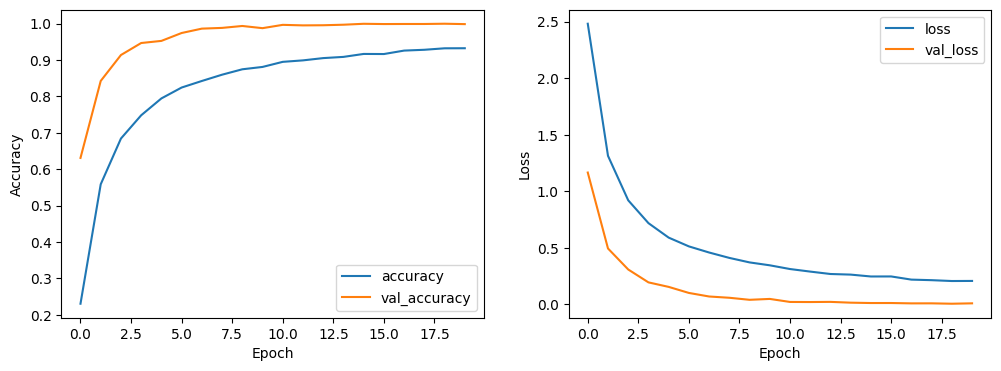

In [ ]:
# Load the dataset
def load_data():
    train = np.loadtxt('sign_mnist_train.csv', delimiter=',', skiprows=1)
    test = np.loadtxt('sign_mnist_test.csv', delimiter=',', skiprows=1)

    X_train = train[:, 1:].reshape(-1, 28, 28, 1)
    y_train = train[:, 0]
    X_test = test[:, 1:].reshape(-1, 28, 28, 1)
    y_test = test[:, 0]

    return (X_train, y_train), (X_test, y_test)

# Load data
(X_train, y_train), (X_test, y_test) = load_data()

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# One hot encode the labels
y_train = to_categorical(y_train, num_classes=25)
y_test = to_categorical(y_test, num_classes=25)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

# Mixed pooling layer
def mixed_pooling(x, pool_size=(2, 2), alpha=0.5):
    max_pool = MaxPooling2D(pool_size=pool_size)(x)
    avg_pool = AveragePooling2D(pool_size=pool_size)(x)
    return alpha * max_pool + (1 - alpha) * avg_pool

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation=mish, input_shape=(28, 28, 1)),
    Lambda(mixed_pooling),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation=mish),
    Lambda(mixed_pooling),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation=mish),
    Lambda(mixed_pooling),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation=mish),
    Dropout(0.5),
    Dense(25, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val)
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
model.save('/content/sign_language_mnist_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 129ms/step
 for /content/A.png: A
 for /content/p.png: P
 for /content/U.png: U
 for /content/R.png: R
 for /content/B.png: B
 for /content/A.png: A


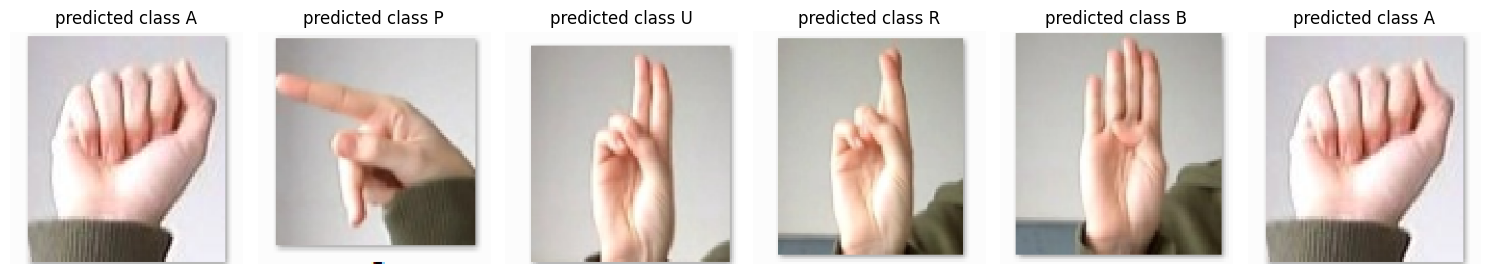

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


# Load the trained model
with tf.keras.utils.custom_object_scope({'mish': mish, 'mixed_pooling': mixed_pooling}):
    model = load_model('/content/sign_language_mnist_model.h5')

# Function to preprocess a batch of images
def preprocess_images(img_paths):
    processed_images = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(28,28), color_mode='grayscale')
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        processed_images.append(img_array)
    processed_images = np.array(processed_images)
    return processed_images

# Paths to the test images (replace with your actual paths)
img_paths = ['/content/A.png', '/content/p.png', '/content/U.png' , '/content/R.png','/content/B.png', '/content/A.png']

# Preprocess the batch of images
processed_images = preprocess_images(img_paths)

# Make predictions
predictions = model.predict(processed_images)
predicted_classes = np.argmax(predictions, axis=1)

# Define class labels (assuming 25 classes)
class_labels = [chr(i) for i in range(65, 65+25)]  # A-Z (excluding J and Z for 25 classes)

# Print predicted classes for each image
for i, predicted_class in enumerate(predicted_classes):
    print(f" for {img_paths[i]}: {class_labels[predicted_class]}")

# Visualize predictions for each image
def visualize_predictions(img_paths, predicted_classes, class_labels):
    fig, axs = plt.subplots(1, len(img_paths), figsize=(15, 5))
    for i, (img_path, predicted_class) in enumerate(zip(img_paths, predicted_classes)):
        img = image.load_img(img_path, target_size=(224, 224))
        axs[i].imshow(img)
        axs[i].set_title(f"predicted class {class_labels[predicted_class]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(img_paths, predicted_classes, class_labels)
